In [1]:
import argparse
import copy
from random import randint
from Bio import Seq, SeqIO, SeqRecord
from difflib import SequenceMatcher
from graphviz import Digraph


def get_reads(seq, read_len, num_reads, k):
    reads = []

    for _ in range(num_reads):
        read = fragment_read(seq, read_len)
        if len(read) > k:
            reads.append(read)

    return reads


def fragment_read(seq, frag_len):
    ind = randint(-frag_len / 2, len(seq) - 1)
    if (ind < 0):
        frag_len = frag_len + ind
        ind = 0

    if ind + frag_len >= len(seq):
        return seq[ind:]
    else:
        return seq[ind : ind + frag_len]


def get_coverage(seq_len, reads, num_reads):
    avg_read_len = 0

    for read in reads:
        avg_read_len += len(read)
        avg_read_len /= len(reads)

    return num_reads * (avg_read_len / seq_len)


def get_kmers(k, reads, read_len):
    kmer_set = set()

    for read in reads:
        if k > read_len:
            print("k for kmer is greater than read length")
            exit(1)
        elif k <= len(read):
            for i in range(len(read) - k + 1):
                kmer_set.add(read[i : i + k])

    return kmer_set


def find_next_kmers(kmer, kmer_set):
    followers = []

    for other in kmer_set:
        if kmer != other and kmer[1:] == other[:-1]:
            followers.append(other)

    return followers

In [2]:
import networkx as nx

def build_debruijn(kmer_set):
    graph = nx.Graph()
    reverse_graph = nx.Graph()

    for kmer in kmer_set:
        followers = find_next_kmers(kmer, kmer_set)
        graph.add_edges_from([(kmer, f) for f in set(followers)])

        for follower in followers:
            if follower in reverse_graph:
                reverse_graph.add_edge(follower, kmer)
            else:
                reverse_graph.add_node(follower)
                reverse_graph.add_edge(follower, kmer)

    for key in graph:
        if key not in reverse_graph:
            reverse_graph.add_node(key)

    return graph, reverse_graph

6 words


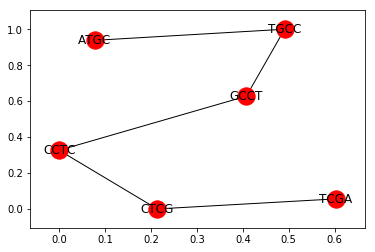

In [81]:
from matplotlib import pyplot as plt
%matplotlib inline

sample = "ATGGAAGTCGCGGAATC"
bsample = "ATGCCTCGA"

k = 4
num_reads = 500
read_len = 10

reads = get_reads(bsample, read_len, num_reads, k)

coverage = get_coverage(len(sample), reads, num_reads)

kmers = np.asarray(sorted(get_kmers(k, reads, read_len)))
print(len(kmers), "words")

debruijn, rev_debruijn = build_debruijn(kmers)

nx.draw_networkx(debruijn)
plt.show()

In [82]:
kmers.itemsize

16

In [83]:
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
import numpy as np

word_bytes = np.ndarray((kmers.size, kmers.itemsize),
                        dtype="int8",
                        buffer=kmers.data)
word_bytes.shape

(6, 16)

In [84]:
hamming_dist = pdist(word_bytes, metric="hamming")
graph = sparse.csr_matrix(squareform(hamming_dist < 1.01 / kmers.itemsize))

graph.shape

(6, 6)

In [85]:
kmers

array(['ATGC', 'CCTC', 'CTCG', 'GCCT', 'TCGA', 'TGCC'],
      dtype='<U4')

In [86]:
word_bytes

array([[65,  0,  0,  0, 84,  0,  0,  0, 71,  0,  0,  0, 67,  0,  0,  0],
       [67,  0,  0,  0, 67,  0,  0,  0, 84,  0,  0,  0, 67,  0,  0,  0],
       [67,  0,  0,  0, 84,  0,  0,  0, 67,  0,  0,  0, 71,  0,  0,  0],
       [71,  0,  0,  0, 67,  0,  0,  0, 67,  0,  0,  0, 84,  0,  0,  0],
       [84,  0,  0,  0, 67,  0,  0,  0, 71,  0,  0,  0, 65,  0,  0,  0],
       [84,  0,  0,  0, 71,  0,  0,  0, 67,  0,  0,  0, 67,  0,  0,  0]], dtype=int8)

In [87]:
hamming_dist

array([ 0.1875,  0.1875,  0.25  ,  0.1875,  0.1875,  0.1875,  0.1875,
        0.1875,  0.1875,  0.1875,  0.25  ,  0.1875,  0.1875,  0.1875,
        0.1875])

In [88]:
squareform(hamming_dist < 1.01 / kmers.itemsize)

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]], dtype=bool)

In [63]:
i1 = kmers.searchsorted("ATGGAAG")
print(i1, kmers[i1])

i2 = kmers.searchsorted("GTCGCGG")
print(i2, kmers[i2])

distances, predecessors = sparse.csgraph.shortest_path(graph, return_predecessors=True)
"distance from '%s' to '%s': %i steps" % (kmers[i1], kmers[i2], distances[i1, i2])

2 ATGGAAG
8 GTCGCGG


OverflowError: cannot convert float infinity to integer

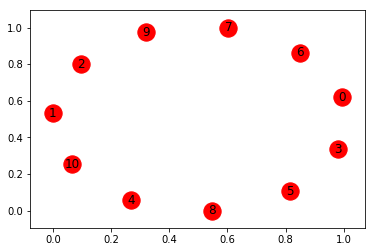

In [48]:
import networkx as nx

nx.draw_networkx(nx.Graph(graph))